# Santander Value Prediction Challenge

#### Eden Trainor

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#Set test colurs to white for dark theme notebook
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [2]:
USER_NAME = 'EdenTrainor' #Configure this with your username

DATA_REPO = 'C:/Users/' + USER_NAME + '/Datalytyx/Delivery - Documents/Data Science/Data/'

TRAIN_FOLDER = 'Santander_Value_Prediction/train.csv'
TEST_FOLDER = 'Santander_Value_Prediction/test.csv'

df = pd.read_csv(DATA_REPO + TRAIN_FOLDER)

#### First look at dataset:

In [3]:
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


#### Remove ID from data, and seperate off target labels


In [4]:
#Use target as labels
labels = df['target']

#Turn column labels into np.array to easily index out ID and target columns
features = df[df.columns.values[2:]]

#set zise variables for readability
total_columns = features.shape[1]
total_examples = features.shape[0]

## Data Cleaning and Sparsity Analysis

#### Look at how many values are NaNs:

In [5]:
total_nans = features.isna().sum().sum()
total_fields = (total_columns*total_examples)

percent_empty = total_nans/total_fields*100

print("{:.2f}".format(percent_empty))

0.00


Yay!! No missing values!!

#### Lets see if any of the columns have zero variance:

In [6]:
variance_per_column = features.var(axis = 'index')
num_invarient = (variance_per_column == 0).sum()

print("{}".format(num_invarient))

256


We have 256 invarient, and therefore unimforamtive, columns to be removed.

#### Lets drop those columns from our DataFrame:

In [7]:
#Array with count of unique values per column: [count_for_col_1, count_for_col2, ...]
unique_vals_count = features.nunique()

#Select only columns of DataFrame with more than one unique value
features = features.loc[:, unique_vals_count != 1]

total_columns = features.shape[1]

This leaves us with 4993 - 256 = 4737 columns

#### Lets look at just how sparse the dataset is:

In [8]:
total_zeros = (features == 0).astype(int).sum().sum()

percent_zero = total_zeros/total_fields*100

print("{:.2f}".format(percent_zero))

91.72


Clearly this is a very sparse dataset; 91.72% empty!

There are many optimizations and methods specific to sparese data, we'll need to look into those.

#### Lets see if any of the columns are dense:

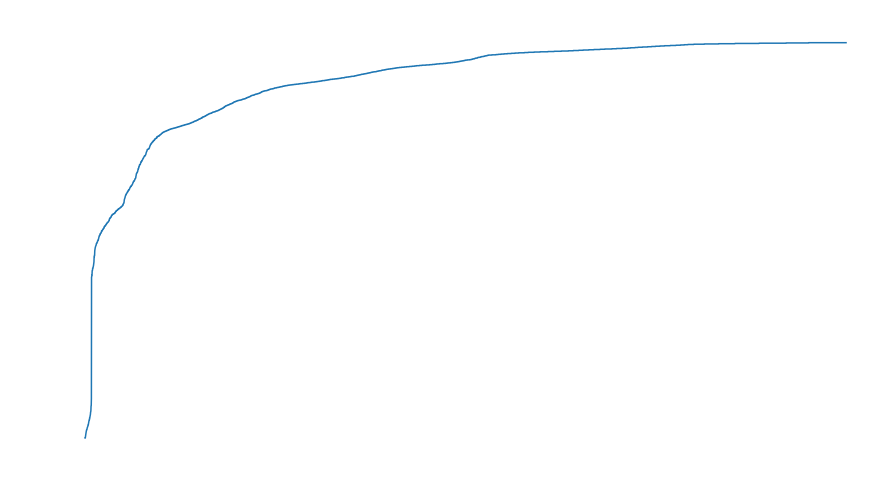

In [9]:
#Count the zeros in each column and then sort the counts into ascending order
sparsity_counts_asc = (features == 0).sum(axis = 'index').values
sparsity_counts_asc.sort()

sparsity_percent_asc = sparsity_counts_asc*100/total_examples

#Plot the count to see ditribution
fig, ax = plt.subplots(1, 1, figsize = (15,8))
ax.plot(np.arange(total_columns), sparsity_percent_asc)
ax.set_title('Percent Zero Values Per Feature - Sorted', color = 'w')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Features')
plt.show()

From the above graph it looks like some fields are almost completely empty, so lets look at the upper tail end.

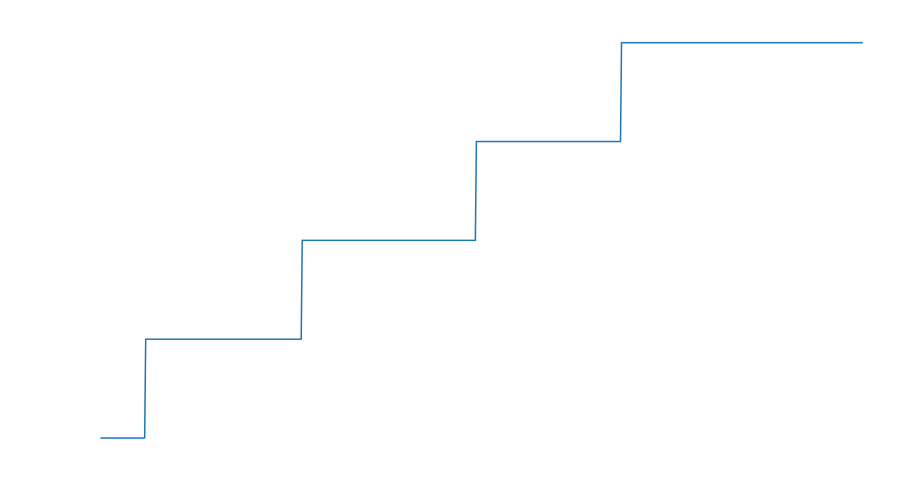

In [10]:
LOWER_LIMIT = 4000
UPPER_LIMIT = total_columns
sparsity_counts_upper = sparsity_counts_asc[LOWER_LIMIT:UPPER_LIMIT]


#Plot the count to see ditribution
fig, ax = plt.subplots(1, 1, figsize = (15,8))
ax.plot(np.arange(total_columns - LOWER_LIMIT), sparsity_counts_upper)
ax.set_title('Percent Zero Values Per Feature - Sorted', color = 'w')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Features')
plt.show()

#### We now know our DataFrame contains:
- No Nans
- Variant features only
- Features are very sparse

## Exploratory Data Analysis

#### Investigate most sparse features to see if they have a correlation to the score

Otherwise we ditch them?

In [11]:
#How many values per feature column are in the lowest band?
most_zeros = sparsity_counts_asc[-1]


sparsity_counts_asc[sparsity_counts_asc == most_zeros].shape[0]

233

Lets look at those feature columns only:

Text(0.5,1,'Plot of Most Sparse Features')

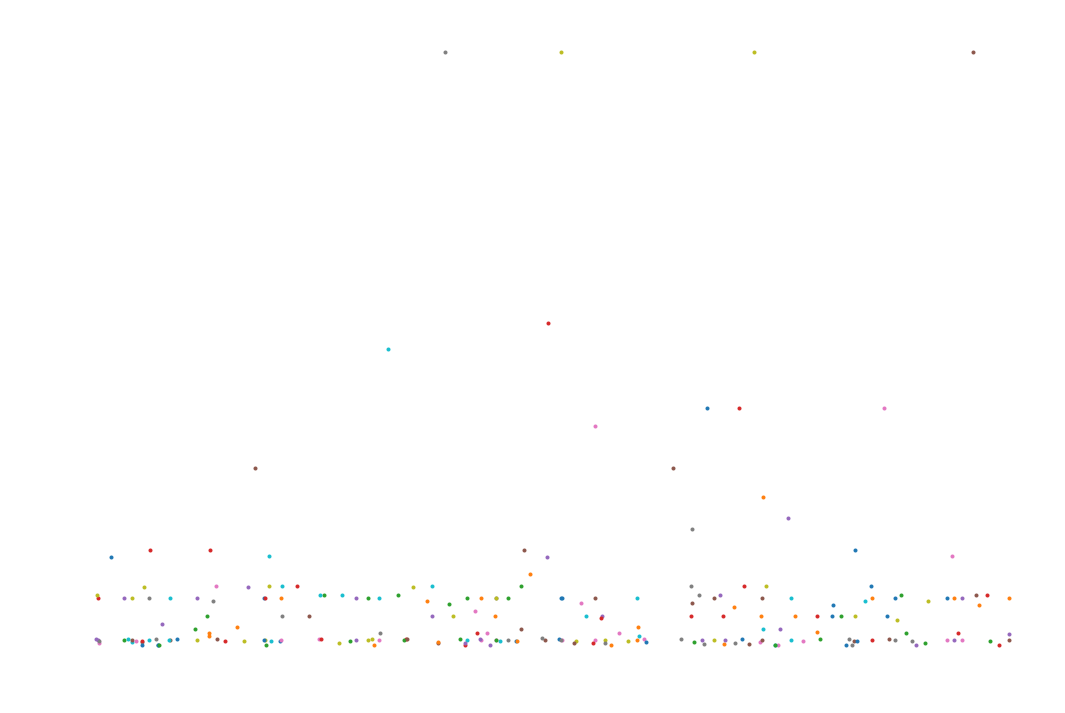

In [12]:
#DataFrame with only the lowest populated columns
tail_df = features.loc[:, ((features == 0).sum(axis = 'index') == most_zeros).values]

ax = tail_df.replace({0:np.nan}).plot(style = '.', #Replaced zeros with nans so they aren't plotted
                legend = False,
                figsize = (18,12),
                title ='Plot of Raw Data Without Scaling')
ax.set_xlabel('Examples')
ax.set_ylabel('Value')
ax.set_title('Plot of Most Sparse Features', color = 'w')

Look at unique values in entire dataset

In [16]:
total_unique_values = np.unique(features.values).shape

In [17]:
total_non_zero = (total_columns*total_examples)-(features.values == 0).sum()
total_unique_values/total_non_zero*100

array([1.27994355])

#### Investigate the standard deviation of each feature:

In [18]:
import dlxtools

In [19]:
dlxtools.__all__

['feature_selection',
 'model_selection',
 'pipelines',
 'preprocessing',
 'random']

In [20]:
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [56]:
#Set the number of principle componants to calculate
N_COMPONENTS = 4459 #FOR SOME REASON PCA HAS A LIMIT OF HOW MANY COMPONENTS IT CAN RETURN
#Define Pipeline into 
pipe = Pipeline([('scl', RobustScaler()),
('pca', PCA(n_components = N_COMPONENTS))])



In [57]:
#Output principle components into a dataframe
_pca = pd.DataFrame(pipe.fit_transform(features.values))

Text(0.5,1,'Plot of Principle Components')

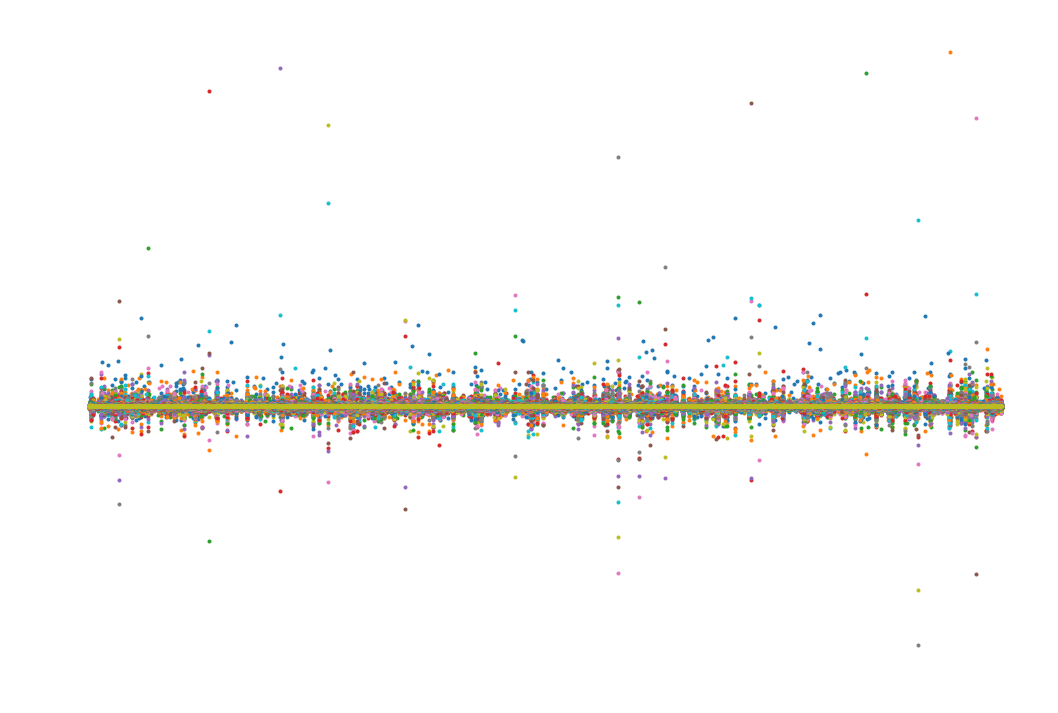

In [58]:
#Plot the principle components
ax = _pca.plot(style = '.', #Replaced zeros with nans so they aren't plotted
                legend = False,
                figsize = (18,12),
                title ='Plot of Raw Data Without Scaling')
ax.set_xlabel('Examples')
ax.set_ylabel('Value')
ax.set_title('Plot of Principle Components', color = 'w')

In [59]:
#Look at ratio of explained variances
pca_variance_ratios = pipe.get_params(True)['pca'].explained_variance_ratio_
# pca_variance_ratios.shape[0] == N_COMPONENTS
print(N_COMPONENTS, pca_variance_ratios.shape[0])

4459 4459


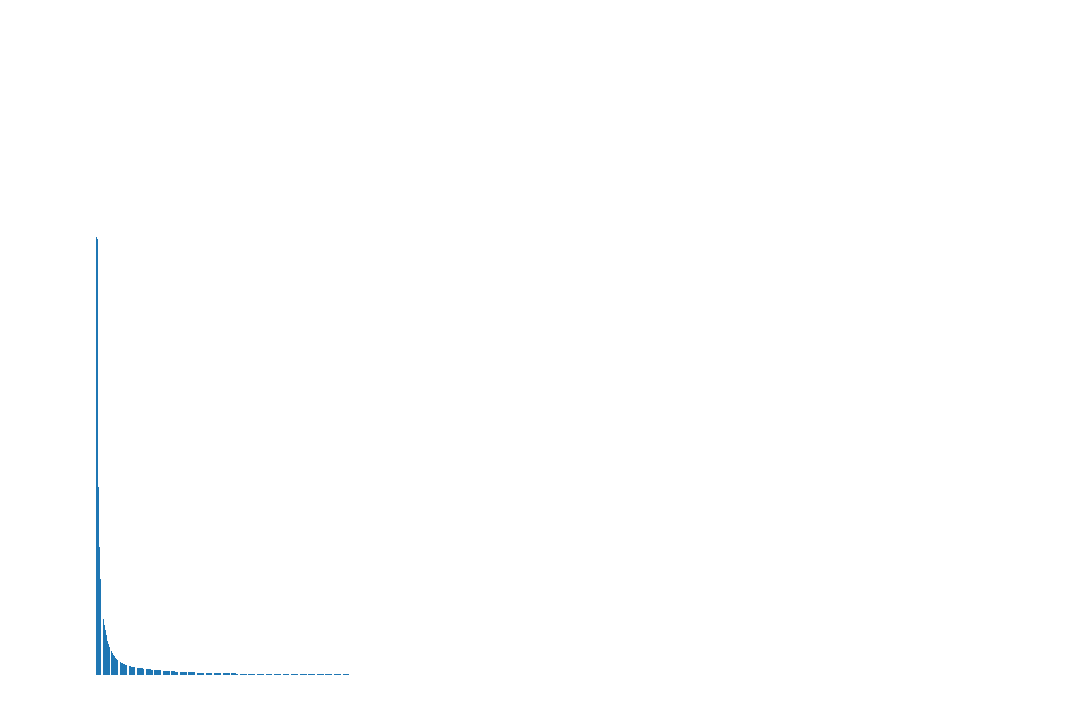

In [60]:
#Plot the count to see distribution
fig, ax = plt.subplots(1, 1, figsize = (18,12))
ax.bar(np.arange(pca_variance_ratios.shape[0]), pca_variance_ratios)
ax.set_title('Principle Component Explained Variance Ratios', color = 'w')
ax.set_ylabel('Ratio')
ax.set_xlabel('Component')
plt.show()

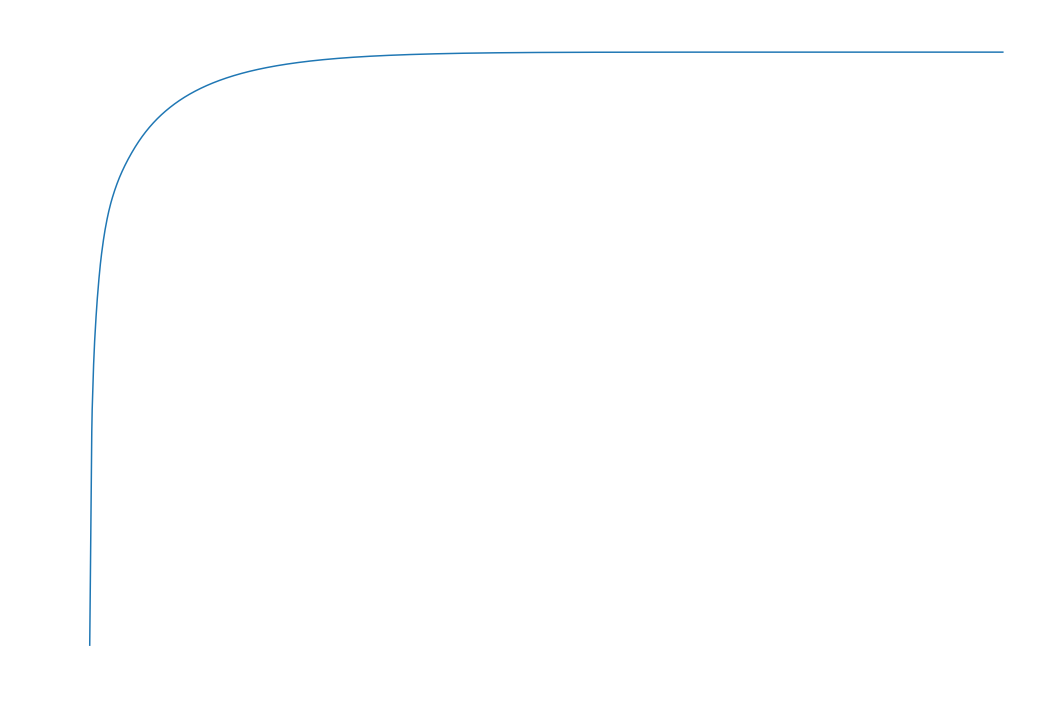

In [63]:
#Cumulative Variance explains
cumulative_variance_ratios = pca_variance_ratios.cumsum()

#Plot the count to see distribution
fig, ax = plt.subplots(1, 1, figsize = (18,12))
ax.plot(np.arange(N_COMPONENTS), cumulative_variance_ratios)
ax.set_title('Principle Component Explained Variance Ratios', color = 'w')
ax.set_ylabel('Cumulative Ratio')
ax.set_xlabel('Principle Component Number')
plt.show()

In [68]:
index = (cumulative_variance_ratios>0.799)*(cumulative_variance_ratios<0.801)
fifth_range = np.where(index)

In [76]:
fifth_range[0][2]


147

In [80]:
cumulative_variance_ratios[:fifth_range[0][2]]


array([0.05022804, 0.08559802, 0.12095353, 0.15628784, 0.19159207,
       0.22689115, 0.26218145, 0.29744494, 0.33269155, 0.36790581,
       0.39213172, 0.41242931, 0.42762532, 0.43854543, 0.44915888,
       0.45967862, 0.47005025, 0.4803701 , 0.49051745, 0.500055  ,
       0.50820969, 0.51625464, 0.52399456, 0.53069535, 0.5373656 ,
       0.54341092, 0.54932505, 0.55503691, 0.56064742, 0.56616268,
       0.57157009, 0.57682002, 0.58199349, 0.58702762, 0.59180157,
       0.59647306, 0.60099308, 0.60539726, 0.60957931, 0.61368792,
       0.61777084, 0.62178323, 0.62573875, 0.62957717, 0.63340159,
       0.63706352, 0.64067317, 0.64421356, 0.64768717, 0.65102906,
       0.65432211, 0.65758017, 0.66070007, 0.66378248, 0.66664986,
       0.66947005, 0.67222674, 0.6749344 , 0.67757559, 0.68013473,
       0.68266663, 0.68516225, 0.68763087, 0.69005921, 0.69245114,
       0.69473843, 0.69700736, 0.69923481, 0.70140418, 0.70355601,
       0.70566231, 0.70774095, 0.70978782, 0.71180005, 0.71376